In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

import gradio as gr

/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = './survey.csv'
data_file = pd.read_csv(path) #using pandas to read a CSV file
data_file.info() #displaying info
data_file.head() #displaying head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [3]:
nonNAN_count = data_file.count().to_numpy()[:-2] #counting the entries
max_entries = np.amax(nonNAN_count)
unusable = [i for i in range(len(nonNAN_count)) if nonNAN_count[i]< np.amax(nonNAN_count)] #evaluating which variables are not usable
labels = list(data_file.columns) #getting protein names
dropped = []
for i in unusable:
  print(labels[i]) #displaying unusable variables
  dropped.append(labels[i]) #making a list of unusable variables

state
self_employed
work_interfere


In [4]:
dropped.append('comments')
new_data_file = data_file.drop(dropped , axis = 1) #new data set formed after removal of unused data
new_data_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   family_history             1259 non-null   object
 5   treatment                  1259 non-null   object
 6   no_employees               1259 non-null   object
 7   remote_work                1259 non-null   object
 8   tech_company               1259 non-null   object
 9   benefits                   1259 non-null   object
 10  care_options               1259 non-null   object
 11  wellness_program           1259 non-null   object
 12  seek_help                  1259 non-null   object
 13  anonymity                  1259 non-null   object
 14  leave   

In [5]:
labelDict = {}
for feature in new_data_file:
    le = preprocessing.LabelEncoder()
    le.fit(new_data_file[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    new_data_file[feature] = le.transform(new_data_file[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
for key, value in labelDict.items():
    print(key, value)
#Get rid of 'Country'
new_data_file = new_data_file.drop(['Country', 'Timestamp', 'Gender'], axis= 1)
new_data_file.head()

label_Timestamp ['2014-08-27 11:29:31', '2014-08-27 11:29:37', '2014-08-27 11:29:44', '2014-08-27 11:29:46', '2014-08-27 11:30:22', '2014-08-27 11:31:22', '2014-08-27 11:31:50', '2014-08-27 11:32:05', '2014-08-27 11:32:39', '2014-08-27 11:32:43', '2014-08-27 11:32:44', '2014-08-27 11:32:49', '2014-08-27 11:33:23', '2014-08-27 11:33:26', '2014-08-27 11:33:57', '2014-08-27 11:34:00', '2014-08-27 11:34:20', '2014-08-27 11:34:37', '2014-08-27 11:34:53', '2014-08-27 11:35:08', '2014-08-27 11:35:12', '2014-08-27 11:35:24', '2014-08-27 11:35:48', '2014-08-27 11:36:24', '2014-08-27 11:36:48', '2014-08-27 11:37:08', '2014-08-27 11:37:23', '2014-08-27 11:37:59', '2014-08-27 11:38:12', '2014-08-27 11:38:18', '2014-08-27 11:38:55', '2014-08-27 11:39:03', '2014-08-27 11:39:31', '2014-08-27 11:39:36', '2014-08-27 11:40:51', '2014-08-27 11:41:17', '2014-08-27 11:41:37', '2014-08-27 11:41:50', '2014-08-27 11:42:08', '2014-08-27 11:42:15', '2014-08-27 11:42:25', '2014-08-27 11:42:31', '2014-08-27 11:43

,Age,family_history,treatment,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,25,0,1,4,0,1,2,1,1,2,2,2,1,1,1,2,1,0,2,0
1,32,0,0,5,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
2,20,0,0,4,0,1,1,0,1,1,0,1,1,1,2,2,2,2,1,0
3,19,1,1,2,0,1,1,2,1,1,1,1,2,2,1,0,0,0,1,1
4,19,0,0,1,1,1,2,0,0,0,0,0,1,1,1,2,2,2,0,0


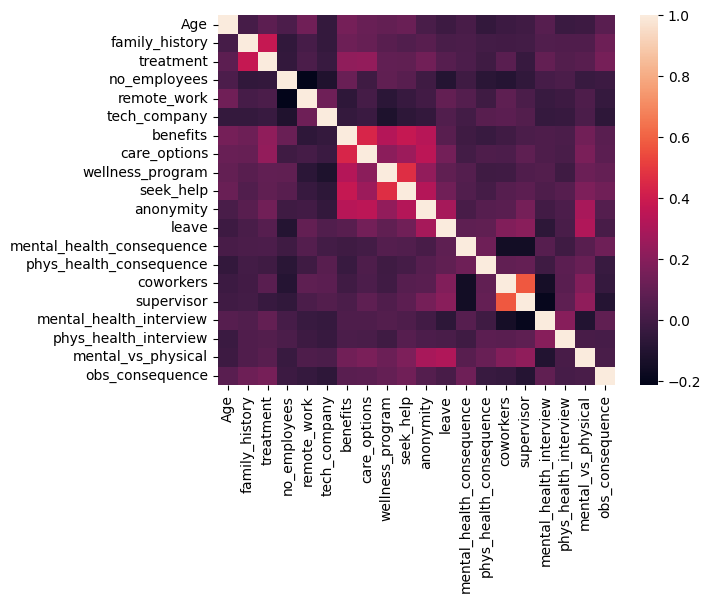

In [6]:
corr_matrix = new_data_file.corr() #calculating the correlation matrix
data_plot = sns.heatmap(corr_matrix) #heatmap
plt.show()

In [7]:
corr_numpy = corr_matrix.to_numpy() #converting corr matrix to numpy for easy work ahead
high = 0
moderate = 0
low = 0
very_high = 0
unusable = []
for i in range(len(corr_numpy)):
  for j in range(len(corr_numpy[0])):
    if abs(corr_numpy[i][j])>0.9:
      very_high = very_high +1
      unusable.append([i,j])
    elif abs(corr_numpy[i][j])>0.5: high = high +1
    elif abs(corr_numpy[i][j])>0.2: moderate = moderate +1
    else: low = low +1
print(very_high, high, moderate, low)
print(unusable)

20 2 40 338
[[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13], [14, 14], [15, 15], [16, 16], [17, 17], [18, 18], [19, 19]]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Age                        1259 non-null   int64
 1   family_history             1259 non-null   int64
 2   treatment                  1259 non-null   int64
 3   no_employees               1259 non-null   int64
 4   remote_work                1259 non-null   int64
 5   tech_company               1259 non-null   int64
 6   benefits                   1259 non-null   int64
 7   care_options               1259 non-null   int64
 8   wellness_program           1259 non-null   int64
 9   seek_help                  1259 non-null   int64
 10  anonymity                  1259 non-null   int64
 11  leave                      1259 non-null   int64
 12  mental_health_consequence  1259 non-null   int64
 13  phys_health_consequence    1259 non-null   int64
 14  coworkers               

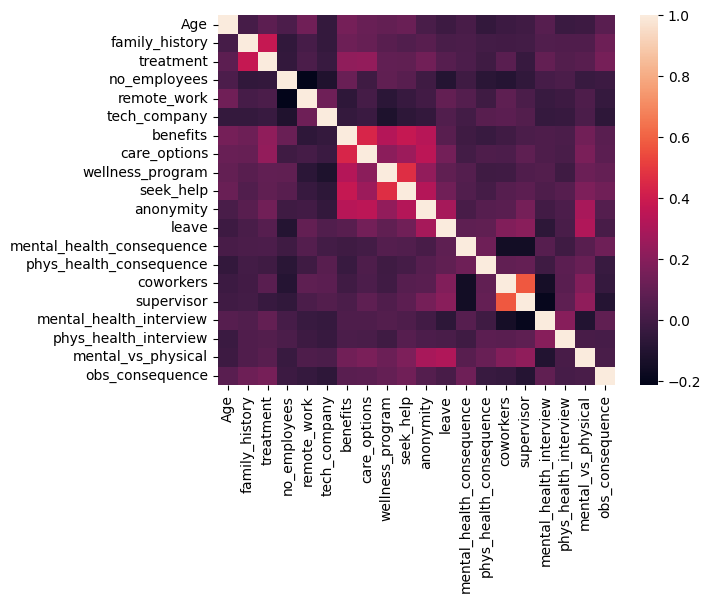

In [8]:

new_data_file.info()
corr_matrix = new_data_file.corr() #calculating the correlation matrix
data_plot = sns.heatmap(corr_matrix) #heatmap
plt.show()

In [9]:
def top5(df):
    """Given dataframe, generate top 5 unique values for non-numeric data"""
    columns = df.select_dtypes(include=['object', 'category']).columns
    for col in columns:
        print("Top 5 unique values of " + col)
        print(df[col].value_counts().reset_index().rename(columns={"index": col, col: "Count"})[
              :min(5, len(df[col].value_counts()))])
        print(" ")


def categorical_eda(df, hue=None):
    """Given dataframe, generate EDA of categorical data"""
    print("\nTo check: \nUnique count of non-numeric data\n")
    print(df.select_dtypes(include=['object', 'category']).nunique())
    top5(df)
    # Plot count distribution of categorical data
    for col in df.select_dtypes(include='category').columns:
        fig = sns.catplot(x=col, kind="count", data=df, hue=hue)
        fig.set_xticklabels(rotation=90)
        plt.show()

# EDA of categorical data
categorical_eda(data_file)


To check: 
Unique count of non-numeric data

Timestamp                    1246
Gender                         49
Country                        48
state                          45
self_employed                   2
family_history                  2
treatment                       2
work_interfere                  4
no_employees                    6
remote_work                     2
tech_company                    2
benefits                        3
care_options                    3
wellness_program                3
seek_help                       3
anonymity                       3
leave                           5
mental_health_consequence       3
phys_health_consequence         3
coworkers                       3
supervisor                      3
mental_health_interview         3
phys_health_interview           3
mental_vs_physical              3
obs_consequence                 2
comments                      160
dtype: int64
Top 5 unique values of Timestamp
                 Count  

In [10]:
y1 = data_file['treatment']

x_train, x_test, y_train, y_test = train_test_split(new_data_file, y1, test_size = 0.2, random_state = 0)
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [0.01]}
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
grid.fit(x_train, y_train)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


grid_predictions = grid.predict(x_test)

# print classification report
print(confusion_matrix(y_test, grid_predictions))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.767 total time=   0.0s
[CV 2/5] END .................C=0.1, gamma=0.01;, score=0.762 total time=   0.0s
[CV 3/5] END .................C=0.1, gamma=0.01;, score=0.682 total time=   0.0s
[CV 4/5] END .................C=0.1, gamma=0.01;, score=0.766 total time=   0.0s
[CV 5/5] END .................C=0.1, gamma=0.01;, score=0.706 total time=   0.0s
[CV 1/5] END ...................C=1, gamma=0.01;, score=0.990 total time=   0.0s
[CV 2/5] END ...................C=1, gamma=0.01;, score=0.990 total time=   0.0s
[CV 3/5] END ...................C=1, gamma=0.01;, score=0.990 total time=   0.0s
[CV 4/5] END ...................C=1, gamma=0.01;, score=0.985 total time=   0.0s
[CV 5/5] END ...................C=1, gamma=0.01;, score=0.980 total time=   0.0s
[CV 1/5] END ..................C=10, gamma=0.01;, score=1.000 total time=   0.0s
[CV 2/5] END ..................C=10, gamma=0.01;,

In [11]:
y1 = data_file['treatment']

x_train, x_test, y_train, y_test = train_test_split(new_data_file, y1, test_size = 0.2, random_state = 0)
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
grid.fit(x_train, y_train)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


grid_predictions = grid.predict(x_test)

# print classification report
print(confusion_matrix(y_test, grid_predictions))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.515 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.515 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.517 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.517 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.512 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.614 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.604 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.622 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.567 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.567 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.767 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [12]:
y1 = data_file['treatment']

x_train, x_test, y_train, y_test = train_test_split(new_data_file, y1, test_size = 0.2, random_state = 0)

classifier = MLPClassifier(max_iter = 500)

param_grid = {'hidden_layer_sizes': [16, 32, 64, 128],
              'learning_rate_init': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}
grid = GridSearchCV(classifier, param_grid, refit = True, verbose = 3, error_score = 'raise')
grid.fit(x_train, y_train)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(x_test)

# print classification report
print(confusion_matrix(y_test, grid_predictions))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END hidden_layer_sizes=16, learning_rate_init=1;, score=0.515 total time=   0.0s
[CV 2/5] END hidden_layer_sizes=16, learning_rate_init=1;, score=0.515 total time=   0.0s
[CV 3/5] END hidden_layer_sizes=16, learning_rate_init=1;, score=0.483 total time=   0.0s
[CV 4/5] END hidden_layer_sizes=16, learning_rate_init=1;, score=0.517 total time=   0.0s
[CV 5/5] END hidden_layer_sizes=16, learning_rate_init=1;, score=0.512 total time=   0.0s
[CV 1/5] END hidden_layer_sizes=16, learning_rate_init=0.1;, score=1.000 total time=   0.0s
[CV 2/5] END hidden_layer_sizes=16, learning_rate_init=0.1;, score=1.000 total time=   0.0s
[CV 3/5] END hidden_layer_sizes=16, learning_rate_init=0.1;, score=1.000 total time=   0.1s
[CV 4/5] END hidden_layer_sizes=16, learning_rate_init=0.1;, score=1.000 total time=   0.0s
[CV 5/5] END hidden_layer_sizes=16, learning_rate_init=0.1;, score=1.000 total time=   0.0s
[CV 1/5] END hidden_layer_si

/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END hidden_layer_sizes=16, learning_rate_init=0.0001;, score=0.866 total time=   0.2s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END hidden_layer_sizes=16, learning_rate_init=0.0001;, score=0.757 total time=   0.3s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END hidden_layer_sizes=16, learning_rate_init=0.0001;, score=0.826 total time=   0.3s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END hidden_layer_sizes=16, learning_rate_init=0.0001;, score=0.836 total time=   0.2s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END hidden_layer_sizes=16, learning_rate_init=0.0001;, score=0.776 total time=   0.3s
[CV 1/5] END hidden_layer_sizes=16, learning_rate_init=1e-05;, score=0.465 total time=   0.1s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END hidden_layer_sizes=16, learning_rate_init=1e-05;, score=0.490 total time=   0.3s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END hidden_layer_sizes=16, learning_rate_init=1e-05;, score=0.398 total time=   0.3s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END hidden_layer_sizes=16, learning_rate_init=1e-05;, score=0.483 total time=   0.3s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END hidden_layer_sizes=16, learning_rate_init=1e-05;, score=0.498 total time=   0.3s
[CV 1/5] END hidden_layer_sizes=32, learning_rate_init=1;, score=0.515 total time=   0.0s
[CV 2/5] END hidden_layer_sizes=32, learning_rate_init=1;, score=0.515 total time=   0.0s
[CV 3/5] END hidden_layer_sizes=32, learning_rate_init=1;, score=0.483 total time=   0.0s
[CV 4/5] END hidden_layer_sizes=32, learning_rate_init=1;, score=0.483 total time=   0.0s
[CV 5/5] END hidden_layer_sizes=32, learning_rate_init=1;, score=0.488 total time=   0.0s
[CV 1/5] END hidden_layer_sizes=32, learning_rate_init=0.1;, score=1.000 total time=   0.0s
[CV 2/5] END hidden_layer_sizes=32, learning_rate_init=0.1;, score=1.000 total time=   0.0s
[CV 3/5] END hidden_layer_sizes=32, learning_rate_init=0.1;, score=1.000 total time=   0.0s
[CV 4/5] END hidden_layer_sizes=32, learning_rate_init=0.1;, score=1.000 total time=   0.0s
[CV 5/5] END hidden_layer_sizes=32, learning_rate_init=0.1;, score=1.000 total time=   0

/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END hidden_layer_sizes=32, learning_rate_init=0.0001;, score=0.955 total time=   0.3s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END hidden_layer_sizes=32, learning_rate_init=0.0001;, score=0.911 total time=   0.3s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END hidden_layer_sizes=32, learning_rate_init=0.0001;, score=0.940 total time=   0.3s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END hidden_layer_sizes=32, learning_rate_init=0.0001;, score=0.915 total time=   0.3s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END hidden_layer_sizes=32, learning_rate_init=0.0001;, score=0.955 total time=   0.3s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END hidden_layer_sizes=32, learning_rate_init=1e-05;, score=0.554 total time=   0.3s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END hidden_layer_sizes=32, learning_rate_init=1e-05;, score=0.574 total time=   0.3s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END hidden_layer_sizes=32, learning_rate_init=1e-05;, score=0.493 total time=   0.3s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END hidden_layer_sizes=32, learning_rate_init=1e-05;, score=0.483 total time=   0.3s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END hidden_layer_sizes=32, learning_rate_init=1e-05;, score=0.602 total time=   0.3s
[CV 1/5] END hidden_layer_sizes=64, learning_rate_init=1;, score=1.000 total time=   0.1s
[CV 2/5] END hidden_layer_sizes=64, learning_rate_init=1;, score=1.000 total time=   0.2s
[CV 3/5] END hidden_layer_sizes=64, learning_rate_init=1;, score=1.000 total time=   0.2s
[CV 4/5] END hidden_layer_sizes=64, learning_rate_init=1;, score=0.517 total time=   0.1s
[CV 5/5] END hidden_layer_sizes=64, learning_rate_init=1;, score=1.000 total time=   0.1s
[CV 1/5] END hidden_layer_sizes=64, learning_rate_init=0.1;, score=1.000 total time=   0.3s
[CV 2/5] END hidden_layer_sizes=64, learning_rate_init=0.1;, score=1.000 total time=   0.1s
[CV 3/5] END hidden_layer_sizes=64, learning_rate_init=0.1;, score=1.000 total time=   0.2s
[CV 4/5] END hidden_layer_sizes=64, learning_rate_init=0.1;, score=1.000 total time=   0.2s
[CV 5/5] END hidden_layer_sizes=64, learning_rate_init=0.1;, score=1.000 total time=   0

/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END hidden_layer_sizes=64, learning_rate_init=0.0001;, score=0.980 total time=   1.2s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END hidden_layer_sizes=64, learning_rate_init=0.0001;, score=0.985 total time=   0.9s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END hidden_layer_sizes=64, learning_rate_init=0.0001;, score=0.950 total time=   1.0s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END hidden_layer_sizes=64, learning_rate_init=0.0001;, score=0.965 total time=   1.5s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END hidden_layer_sizes=64, learning_rate_init=0.0001;, score=0.980 total time=   1.4s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END hidden_layer_sizes=64, learning_rate_init=1e-05;, score=0.683 total time=   1.9s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END hidden_layer_sizes=64, learning_rate_init=1e-05;, score=0.678 total time=   1.8s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END hidden_layer_sizes=64, learning_rate_init=1e-05;, score=0.527 total time=   2.1s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END hidden_layer_sizes=64, learning_rate_init=1e-05;, score=0.746 total time=   2.0s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END hidden_layer_sizes=64, learning_rate_init=1e-05;, score=0.493 total time=   1.4s
[CV 1/5] END hidden_layer_sizes=128, learning_rate_init=1;, score=0.485 total time=   0.2s
[CV 2/5] END hidden_layer_sizes=128, learning_rate_init=1;, score=0.515 total time=   0.2s
[CV 3/5] END hidden_layer_sizes=128, learning_rate_init=1;, score=0.483 total time=   0.7s
[CV 4/5] END hidden_layer_sizes=128, learning_rate_init=1;, score=1.000 total time=   0.3s
[CV 5/5] END hidden_layer_sizes=128, learning_rate_init=1;, score=1.000 total time=   0.3s
[CV 1/5] END hidden_layer_sizes=128, learning_rate_init=0.1;, score=1.000 total time=   0.2s
[CV 2/5] END hidden_layer_sizes=128, learning_rate_init=0.1;, score=1.000 total time=   0.2s
[CV 3/5] END hidden_layer_sizes=128, learning_rate_init=0.1;, score=1.000 total time=   0.3s
[CV 4/5] END hidden_layer_sizes=128, learning_rate_init=0.1;, score=1.000 total time=   0.2s
[CV 5/5] END hidden_layer_sizes=128, learning_rate_init=0.1;, score=1.000 total

/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END hidden_layer_sizes=128, learning_rate_init=0.0001;, score=0.985 total time=   1.3s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END hidden_layer_sizes=128, learning_rate_init=0.0001;, score=0.995 total time=   1.7s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END hidden_layer_sizes=128, learning_rate_init=0.0001;, score=0.980 total time=   1.3s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END hidden_layer_sizes=128, learning_rate_init=0.0001;, score=1.000 total time=   1.2s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END hidden_layer_sizes=128, learning_rate_init=0.0001;, score=1.000 total time=   1.2s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END hidden_layer_sizes=128, learning_rate_init=1e-05;, score=0.827 total time=   3.9s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END hidden_layer_sizes=128, learning_rate_init=1e-05;, score=0.663 total time=   3.9s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END hidden_layer_sizes=128, learning_rate_init=1e-05;, score=0.716 total time=   2.9s


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END hidden_layer_sizes=128, learning_rate_init=1e-05;, score=0.557 total time=   2.6s
[CV 5/5] END hidden_layer_sizes=128, learning_rate_init=1e-05;, score=0.796 total time=   1.6s
{'hidden_layer_sizes': 16, 'learning_rate_init': 0.1}
MLPClassifier(hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=500)
[[134   0]
 [  0 118]]


/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
y1 = data_file['treatment']

x_train, x_test, y_train, y_test = train_test_split(new_data_file, y1, test_size = 0.2, random_state = 0)

classifier = RandomForestClassifier()

param_grid = {'max_depth': [3, 5, 7, 9, 11],
              'max_leaf_nodes': [10, 50, 100, 150, 200]}
grid = GridSearchCV(classifier, param_grid, refit = True, verbose = 3, error_score = 'raise')
grid.fit(x_train, y_train)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(x_test)

# print classification report
print(confusion_matrix(y_test, grid_predictions))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ....max_depth=3, max_leaf_nodes=10;, score=1.000 total time=   0.1s
[CV 2/5] END ....max_depth=3, max_leaf_nodes=10;, score=1.000 total time=   0.1s
[CV 3/5] END ....max_depth=3, max_leaf_nodes=10;, score=1.000 total time=   0.1s
[CV 4/5] END ....max_depth=3, max_leaf_nodes=10;, score=1.000 total time=   0.1s
[CV 5/5] END ....max_depth=3, max_leaf_nodes=10;, score=1.000 total time=   0.1s
[CV 1/5] END ....max_depth=3, max_leaf_nodes=50;, score=1.000 total time=   0.1s
[CV 2/5] END ....max_depth=3, max_leaf_nodes=50;, score=1.000 total time=   0.1s
[CV 3/5] END ....max_depth=3, max_leaf_nodes=50;, score=1.000 total time=   0.1s
[CV 4/5] END ....max_depth=3, max_leaf_nodes=50;, score=1.000 total time=   0.1s
[CV 5/5] END ....max_depth=3, max_leaf_nodes=50;, score=1.000 total time=   0.1s
[CV 1/5] END ...max_depth=3, max_leaf_nodes=100;, score=1.000 total time=   0.1s
[CV 2/5] END ...max_depth=3, max_leaf_nodes=100

In [14]:
y1 = data_file['treatment']

x_train, x_test, y_train, y_test = train_test_split(new_data_file, y1, test_size = 0.2, random_state = 0)

classifier = AdaBoostClassifier()

param_grid = { 'n_estimators': [10, 50, 100, 150, 200],
              'learning_rate': [0.1, 0.01, 0.001, 0.0001]}
grid = GridSearchCV(classifier, param_grid, refit = True, verbose = 3, error_score = 'raise')
grid.fit(x_train, y_train)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(x_test)

# print classification report
print(confusion_matrix(y_test, grid_predictions))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END learning_rate=0.1, n_estimators=10;, score=1.000 total time=   0.0s
[CV 2/5] END learning_rate=0.1, n_estimators=10;, score=1.000 total time=   0.0s
[CV 3/5] END learning_rate=0.1, n_estimators=10;, score=1.000 total time=   0.0s
[CV 4/5] END learning_rate=0.1, n_estimators=10;, score=1.000 total time=   0.0s
[CV 5/5] END learning_rate=0.1, n_estimators=10;, score=1.000 total time=   0.0s
[CV 1/5] END learning_rate=0.1, n_estimators=50;, score=1.000 total time=   0.0s
[CV 2/5] END learning_rate=0.1, n_estimators=50;, score=1.000 total time=   0.0s
[CV 3/5] END learning_rate=0.1, n_estimators=50;, score=1.000 total time=   0.0s
[CV 4/5] END learning_rate=0.1, n_estimators=50;, score=1.000 total time=   0.0s
[CV 5/5] END learning_rate=0.1, n_estimators=50;, score=1.000 total time=   0.0s
[CV 1/5] END learning_rate=0.1, n_estimators=100;, score=1.000 total time=   0.0s
[CV 2/5] END learning_rate=0.1, n_estimators=1

/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: Fu

[CV 2/5] END learning_rate=0.001, n_estimators=100;, score=1.000 total time=   0.0s
[CV 3/5] END learning_rate=0.001, n_estimators=100;, score=1.000 total time=   0.0s
[CV 4/5] END learning_rate=0.001, n_estimators=100;, score=1.000 total time=   0.0s
[CV 5/5] END learning_rate=0.001, n_estimators=100;, score=1.000 total time=   0.0s
[CV 1/5] END learning_rate=0.001, n_estimators=150;, score=1.000 total time=   0.0s
[CV 2/5] END learning_rate=0.001, n_estimators=150;, score=1.000 total time=   0.0s
[CV 3/5] END learning_rate=0.001, n_estimators=150;, score=1.000 total time=   0.0s
[CV 4/5] END learning_rate=0.001, n_estimators=150;, score=1.000 total time=   0.0s
[CV 5/5] END learning_rate=0.001, n_estimators=150;, score=1.000 total time=   0.0s
[CV 1/5] END learning_rate=0.001, n_estimators=200;, score=1.000 total time=   0.0s
[CV 2/5] END learning_rate=0.001, n_estimators=200;, score=1.000 total time=   0.0s
[CV 3/5] END learning_rate=0.001, n_estimators=200;, score=1.000 total time=

/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: Fu

In [15]:
y1 = data_file['treatment']

x_train, x_test, y_train, y_test = train_test_split(new_data_file, y1, test_size = 0.2, random_state = 0)
print(x_test)
classifier = AdaBoostClassifier(learning_rate = 0.1, n_estimators = 10)
classifier.fit(x_train, y_train)
print(classifier.predict(x_test))

      Age  family_history  treatment  no_employees  remote_work  tech_company  \
5      21               1          0             4            0             1   
494    13               0          0             2            0             1   
52     19               0          0             1            1             1   
986    27               1          0             3            1             1   
186    12               0          0             4            0             1   
...   ...             ...        ...           ...          ...           ...   
1137   29               1          0             4            0             1   
31     19               1          0             0            1             1   
408    10               0          0             4            1             1   
64     23               0          0             4            0             1   
747    20               0          0             4            0             1   

      benefits  care_option

/Users/shikharkunalvarma/anaconda3/envs/health_predictor/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [16]:
import gradio as gr



def health(
Age,
family_history,
treatment,
no_employees,
remote_work,
tech_company,
benefits,
care_options,
wellness_program,
seek_help,
anonymity,
leave,
mental_health_consequence,
phys_health_consequence,
coworkers,
supervisor,
mental_health_interview,
phys_health_interview,
mental_vs_physical,
obs_consequence
):
    x_test = [
      Age,
      family_history,
      treatment,
      no_employees,
      remote_work,
      tech_company,
      benefits,
      care_options,
      wellness_program,
      seek_help,
      anonymity,
      leave,
      mental_health_consequence,
      phys_health_consequence,
      coworkers,
      supervisor,
      mental_health_interview,
      phys_health_interview,
      mental_vs_physical,
      obs_consequence
          ]
    x_test = np.zeros(20)
    x_test = np.array(x_test).reshape(1, -1)
    print(len(new_data_file.columns))
    test_file = pd.DataFrame(x_test, columns = new_data_file.columns)
    for feature in test_file:
        le = preprocessing.LabelEncoder()
        le.fit(new_data_file[feature])
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        new_data_file[feature] = le.transform(new_data_file[feature])
        # Get labels
        labelKey = 'label_' + feature
        labelValue = [*le_name_mapping]
        labelDict[labelKey] =labelValue
    # Your logic for processing the input data and generating output
    # ...

    # For now, let's just return a placeholder result
    predictions  = classifier.predict(x_test)
    if predictions[0] == "Yes":
      return "Hi! Based on your responses, it seems like you are doing well. Keep it up!";
    return "Hello! From your responses, it appears that consulting a doctor might be beneficial. Don't worry; we are here for you every step of the way. With the right support, you'll be back on track soon! Take care!"

In [17]:
inputs = [
    gr.Number(value=30, label='Respondent Age'),
    # gr.Radio(['Male', 'Female', 'Other'], label="Respondent gender"),
    # gr.Textbox("India", label="Respondent gender"),
    # gr.Radio(["Rajasthan", "UP", "MP", "Maharashtra"], label="If you live in India, which state or territory do you live in?"),
    # gr.Radio(["Yes", "No", "Other"], label="Are you self-employed?"),
    gr.Radio(["Yes", "No"], label="Do you have a family history of mental illness?"),
    gr.Radio(["Yes", "No"], label="Have you sought treatment for a mental health condition?"),
    # gr.Radio(["Yes", "No", "Don't know"], label="If you have a mental health condition, do you feel that it interferes with your work?"),
    gr.Radio(["1-5","6-25", "26-100", "100-500", "500-1000", "More than 1000"], label="How many employees does your company or organization have?"),
    gr.Radio(["Yes", "No"], label="Do you work remotely (outside of an office) at least 50% of the time?"),
    gr.Radio(["Yes", "No"], label="Is your employer primarily a tech company/organization?"),
    gr.Radio(["Yes", "No","Don't know"], label="Does your employer provide mental health benefits?"),
    gr.Radio(["Yes", "No","Not sure"], label="Do you know the options for mental health care your employer provides?"),
    gr.Radio(["Yes", "No","Don't know"], label="Has your employer ever discussed mental health as part of an employee wellness program?"),
    gr.Radio(["Yes", "No","Don't know"], label="Does your employer provide resources to learn more about mental health issues and how to seek help?"),
    gr.Radio(["Yes", "No","Don't know"], label="Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment"),
    gr.Radio(["Don't know", 'Somewhat difficult', 'Somewhat easy', 'Very difficult', 'Very easy'], label="How easy is it for you to take medical leave for a mental health condition?"),
    gr.Radio(["Yes", "No","Maybe"], label="Do you think that discussing a mental health issue with your employer would have negative consequences?"),
    gr.Radio(["Yes", "No","Maybe"], label="Do you think that discussing a physical health issue with your employer would have negative consequences?"),
    gr.Radio(['No', 'Some of them', 'Yes'], label="Would you be willing to discuss a mental health issue with your coworkers?"),
    gr.Radio(['No', 'Some of them', 'Yes'], label="Would you be willing to discuss a mental health issue with your direct supervisor(s)?"),
    gr.Radio(["Yes", "No","Maybe"], label="Would you bring up a mental health issue with a potential employer in an interview?"),
    gr.Radio(["Yes", "No","Maybe"], label="Would you bring up a physical health issue with a potential employer in an interview?"),
    gr.Radio(["Yes", "No","Don't know"], label="Do you feel that your employer takes mental health as seriously as physical health?"),
    gr.Radio(["Yes", "No"], label="Have you heard of or observed negative consequences for coworkers with mental health conditions in your office?"),
]

demo = gr.Interface(fn=health, inputs=inputs, title = "Mental Health Prediction Test", description = ("Welcome to our online mental health self-assessment tool, designed to guide you in understanding and evaluating your mental well-being. Kindly respond to the following set of questions as we aim to assist you in gaining insights into your mental health. This platform is developed to provide a user-friendly experience for individuals seeking a self-diagnostic resource."), outputs="text")

demo.launch(share=True)


Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2024/01/20 18:35:17 [W] [service.go:132] login to server failed: dial tcp 44.237.78.176:7000: i/o timeout
